Inspect integrator output values, grouping by different equivalence classings on the dataset.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
from collections import Counter
from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings, prepare_dataset

In [6]:
model_dir = "outputs/models/w2v2_32/phoneme_within_word_prefix"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_6_1.pkl"
output_dir = "."

metric = "cosine"

In [8]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [9]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [27]:
0ds = prepare_dataset(equiv_dataset, model.config.max_length, num_examples=min(10000, equiv_dataset.num_instances))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
Counter(["".join(equiv_dataset.class_labels[label_idx]) for label_idx in ds["example_class"].numpy()]).most_common(10)

[('T', 19),
 ('AH', 18),
 ('W', 18),
 ('S', 17),
 ('M', 14),
 ('K', 14),
 ('HH', 14),
 ('DH', 14),
 ('IH', 14),
 ('G', 11)]

In [29]:
losses, idxs = [], []

def compute_loss_batch(batch, batch_idxs):
    with torch.no_grad():
        model_output = model(batch["example"], batch["example_length"],
                             batch["pos"], batch["pos_length"],
                             batch["neg"], batch["neg_length"],
                             loss_reduction=None)
    losses.append(model_output.loss.numpy())
    idxs.append(batch["example_idx"].numpy())
ds.map(compute_loss_batch, batched=True, with_indices=True, batch_size=32)

losses = np.concatenate(losses)
idxs = np.concatenate(idxs)

loss_df = pd.DataFrame({"loss": losses, "idx": idxs, "class": equiv_dataset.Q[idxs]})
loss_df["class_label"] = loss_df["class"].map(lambda idx: " ".join(equiv_dataset.class_labels[idx]))
loss_df["word_length"] = loss_df.class_label.str.count(" ") + 1

Map:   0%|          | 0/912 [00:00<?, ? examples/s]

In [30]:
loss_df

,loss,idx,class,class_label,word_length
0,-1.403934,549340,36,M,1
1,-0.005762,617888,11483,HH AY ER Z,4
2,-19.793495,657674,136,M IY,2
3,-0.927382,690473,11819,D JH AA,3
4,0.337392,144420,299,DH AH,2
...,...,...,...,...,...
907,-14.318390,143812,1063,V Y UW,3
908,-19.787697,600060,1768,S T UW D AH N,6
909,-19.793602,109076,7052,B Y ER AA K ER S,7
910,0.891696,237744,14,AH,1


<Axes: xlabel='loss'>

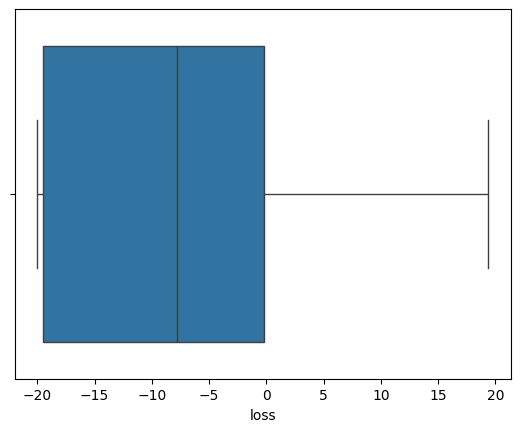

In [31]:
sns.boxplot(data=loss_df, x="loss")

In [21]:
loss_df.to_csv(Path(output_dir) / "loss.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'outputs/notebooks/w2v2_32/phoneme_within_word_prefix/predictions_word'

<Axes: xlabel='word_length', ylabel='loss'>

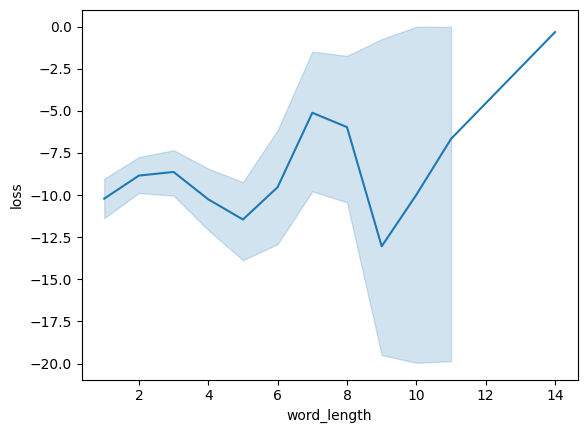

In [32]:
sns.lineplot(data=loss_df, x="word_length", y="loss")